# Evaluation of the `Hagrad`-Optimizer with Mnist-Dataset

"Hagrad" - **Ha**miltonian **Gr**adient **D**escent, based on Maddison, C. J., Paulin, D., Teh, Y. W., O'Donoghue, B., & Doucet, A. (2018). *Hamiltonia Descent Methods*. [arXiv:1809.05042 [math.OC]](arXiv:1809.05042).

Implementation of custom `tf`/`tf.keras` optimizer inspired by [https://cloudxlab.com/blog/writing-custom-optimizer-in-tensorflow-and-keras/](https://cloudxlab.com/blog/writing-custom-optimizer-in-tensorflow-and-keras/)

### Imports and Data

In [1]:
## Tensorflow related
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

## General
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Hagrad custom optimizer
from hagrad import Hagrad

In [2]:
## Fetch Mnist-Dataset
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
assert X_train.shape == (60000, 28, 28)
assert X_test.shape  == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape  == (10000,)

In [3]:
## Class number and sanity check
num_classes = 10
assert np.all(np.sort(np.unique(y_train)) == np.arange(num_classes))

## Normalizing and expanding dimensions for ConvLayers
def perpare_X_data(X: np.ndarray) -> np.ndarray:
    X = X.astype(np.float32) / 255.
    X = np.expand_dims(X, -1)
    return(X)

X_train = perpare_X_data(X_train)
X_test  = perpare_X_data(X_test)

## convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test, num_classes)

### Separation of a validation set

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=42, test_size=0.1)

### Defining Model generating function

Using the proposed convnet from the keras-people from https://keras.io/examples/vision/mnist_convnet/.

In [5]:
def generate_model(
    input_shape: tuple,
    num_classes: int,
    opt: keras.optimizers.Optimizer,
    PRINT_SUMMARY: bool=False
) -> keras.Model:
    model = keras.Sequential(
        [
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=input_shape),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    
    model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=opt, metrics=["accuracy"])

    if PRINT_SUMMARY: print(model.summary())

    return(model)


## Train Models

In [6]:
batch_size  = 128
epochs      = 20
input_shape = X_train.shape[1:]
print(input_shape)

(28, 28, 1)


### Train baseline with SGD and Adam

In [7]:
keras.backend.clear_session()
model_adam = generate_model(input_shape=input_shape, num_classes=num_classes, opt=keras.optimizers.Adam(), PRINT_SUMMARY=True)
fit_adam = model_adam.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid), verbose=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                1

In [8]:
keras.backend.clear_session()
model_sgd = generate_model(input_shape=input_shape, num_classes=num_classes, opt=keras.optimizers.SGD(), PRINT_SUMMARY=False)
fit_sgd = model_sgd.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid), verbose=1)

Epoch 1/20
422/422 [==============================] - 2s 4ms/step - loss: 1.5435 - accuracy: 0.5093 - val_loss: 0.5399 - val_accuracy: 0.8700
Epoch 2/20
422/422 [==============================] - 1s 3ms/step - loss: 0.5516 - accuracy: 0.8280 - val_loss: 0.3148 - val_accuracy: 0.9162
Epoch 3/20
422/422 [==============================] - 1s 3ms/step - loss: 0.3768 - accuracy: 0.8865 - val_loss: 0.2428 - val_accuracy: 0.9342
Epoch 4/20
422/422 [==============================] - 1s 3ms/step - loss: 0.3029 - accuracy: 0.9093 - val_loss: 0.1999 - val_accuracy: 0.9488
Epoch 5/20
422/422 [==============================] - 1s 3ms/step - loss: 0.2620 - accuracy: 0.9213 - val_loss: 0.1762 - val_accuracy: 0.9547
Epoch 6/20
422/422 [==============================] - 1s 3ms/step - loss: 0.2315 - accuracy: 0.9304 - val_loss: 0.1567 - val_accuracy: 0.9595
Epoch 7/20
422/422 [==============================] - 1s 3ms/step - loss: 0.2105 - accuracy: 0.9362 - val_loss: 0.1430 - val_accuracy: 0.9623
Epoch 

In [9]:
keras.backend.clear_session()
model_hagrad = generate_model(input_shape=input_shape, num_classes=num_classes, opt=Hagrad(), PRINT_SUMMARY=False)
fit_hagrad = model_hagrad.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid), verbose=1)

Epoch 1/20
422/422 [==============================] - 3s 5ms/step - loss: 0.2710 - accuracy: 0.9158 - val_loss: 0.0919 - val_accuracy: 0.9772
Epoch 2/20
422/422 [==============================] - 2s 4ms/step - loss: 0.0965 - accuracy: 0.9696 - val_loss: 0.0539 - val_accuracy: 0.9862
Epoch 3/20
422/422 [==============================] - 2s 4ms/step - loss: 0.0786 - accuracy: 0.9755 - val_loss: 0.0474 - val_accuracy: 0.9870
Epoch 4/20
422/422 [==============================] - 2s 4ms/step - loss: 0.0676 - accuracy: 0.9791 - val_loss: 0.0469 - val_accuracy: 0.9865
Epoch 5/20
422/422 [==============================] - 2s 4ms/step - loss: 0.0623 - accuracy: 0.9802 - val_loss: 0.0481 - val_accuracy: 0.9853
Epoch 6/20
422/422 [==============================] - 2s 4ms/step - loss: 0.0573 - accuracy: 0.9820 - val_loss: 0.0399 - val_accuracy: 0.9885
Epoch 7/20
422/422 [==============================] - 2s 4ms/step - loss: 0.0529 - accuracy: 0.9829 - val_loss: 0.0399 - val_accuracy: 0.9895
Epoch 

## Visualizing

In [10]:
epochs_arr = np.arange(epochs)

## Keras is evaluating the validation error in the end of each epoch. 
#  Therefore these values get shifted for the visualization:
epochs_arr_val = epochs_arr + 0.5



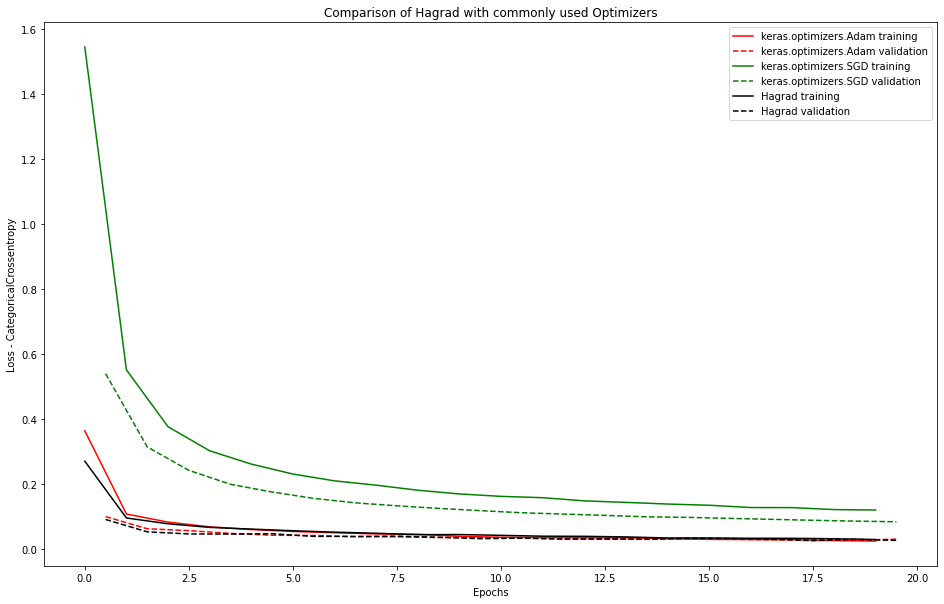

In [11]:
plt.figure(figsize=(16, 10))
plt.title("Comparison of Hagrad with commonly used Optimizers")
plt.plot(epochs_arr, fit_adam.history['loss'], "r-", label="keras.optimizers.Adam training") 
plt.plot(epochs_arr_val, fit_adam.history['val_loss'], "r--", label="keras.optimizers.Adam validation") 
plt.plot(epochs_arr, fit_sgd.history['loss'], "g-", label="keras.optimizers.SGD training") 
plt.plot(epochs_arr_val, fit_sgd.history['val_loss'], "g--", label="keras.optimizers.SGD validation") 
plt.plot(epochs_arr, fit_hagrad.history['loss'], "k-", label="Hagrad training") 
plt.plot(epochs_arr_val, fit_hagrad.history['val_loss'], "k--", label="Hagrad validation") 
plt.xlabel("Epochs")
plt.ylabel("Loss - CategoricalCrossentropy")
plt.legend()
plt.show()